# Demand Estimation Exercise
### Part 0 : Getting started

In this assignment, you will be doing guided demand estimation for heterogeneous product models. The techniques you will use appear often in empirical research and policy scenarios. Imagine you are a practitioner trying to estimate how responsive consumers are to changes in _chocolate_ prices (elasticities of demand with respect to prices). Each firm sells a slightly different chocolate variety so you cannot assume that demand is homogenous. The most common model accounting for heterogeneous products in demand estimation was proposed by Berry (1994). This model was extensively discussed in the lecture. For the assignment, you will obtain estimates for demand elasticities using two estimation measures. Demand elasticities can only be obtained once we know the parameters defining the demand function. The purpose is that you understand how model misspecification leads to biased elasticity estimates and how such biases might impact policy and 
competition authorities decisions. You will use simulated data for which we know the data generation process (DGP) and the true value of the coefficients. A detailed description of the model is provided below. 


**(a) Model description**

Consider a market with $N$ consumers, $J$ firms, across $T$ time periods (you can also see the time periods as geographically separated markets). This is an important assumption for heterogeneous product models, consumers can only activate within one market (Berry & Haile, 2020)). In this simplified model we assume firms are going to sell just one product, therefore firms and products can be used interchangeably. Consumers have heterogeneous preferences over prices. The indirect utility of the consumers is given by: 

$$u_{ijt} = \beta x_j + \alpha_{it}p_{jt} + \xi_{jt} + \varepsilon_{ijt}$$


Where: 
- $x_j$ is a time-invariant product characteristic 
-  $p_{jt}$ is the price of the product sold by firm $j$ in period $t$ 
- $\xi_{jt}$ are product-market specific fixed effects which are correlated with $p_{jt}$
- $\beta$ is the coefficient of the product characteristic and it is constant across consumers 
- $\alpha_{it}$ is the consumer specific price coefficient defined as $\alpha_{it} =  \mu_{\alpha} + \sigma_{\alpha} \nu_{it}^{p}$, where $\nu_{it}^{p}$ are i.i.d. standard normal random variables 
- $\varepsilon_{ijt}$ is the error term following a type-I generalized extreme value distribution.


Following from standard theory we can thereafter rewrite indirect utility as: 

$$u_{i j t}= \delta_{jt} + \sigma_{\alpha} \nu_{it}^{p}p_{jt} + \varepsilon_{ijt},$$ 

where $ \delta_{jt} = \beta x_j + \mu_{\alpha} p_{jt} + \xi_{jt}$. 

Each consumer purchases one unit of the good that gives them the highest utility. Each market has the same number of consumers across time, $N$. By assuming that the error term $\varepsilon_{ijt}$ follows from the type-I extreme value distribution, the probability $f_{ijt}$ that consumer $i$ buys product $j$ in market $t$ is given by the multinomial logit function: 


$$f_{ijt} = \frac{\exp \left(\beta x_j+\alpha_{it} p_{j t}+ \xi_{jt}\right)}{1+\sum_{k=1}^J \exp \left(\beta x_k + \alpha_{it} p_{k t} +\xi_{kt}\right)}.$$



Aggregating over the individual purchasing probabilities we get the market shares: 

$$
    s_{jt}= \int_N f_{ijt} \text{d} \nu.
$$


The model is a simplified and adapted version of the theory from the paper of Berry (1994). For additional information, clarification and theory please check the reference material. 

The assignment makes use of simulated data. The model has been calibrated to the following coefficients. These are the coefficients that you will try to estimate in the assignment. Ultimately, you will use the coefficients to retrieve own-price elasticities of demand: 



| Coefficient    |   True Value   |
|----------------|------|
| $\mu_{\alpha}$    | -1.7 |
| $\beta$        | -1   |
| $\sigma_{\alpha}$ | 0.5  |



In [1]:
# Import the following modules

import numpy as np 
import pandas as pd 
import statsmodels.api as sm
from scipy.stats import norm
from scipy import optimize
import matplotlib.pyplot as plt

### PART 1: Data exploration (10 points)


**Exercise 1**

Look into the data characterizing your market. Print the data. Is it realistic that an econometrician has all the information that you have in your dataset (max 100 words)?

In [2]:
# 1. Load the data using pandas 

df = pd.read_csv("simulation_data.csv")
# 2. Print the data

# Your code here 
print(df)


     market_ids  firm_ids    shares    prices      cost        xi     char1
0             1         1  0.000043  4.914348  3.262528 -0.042173  4.616823
1             1         2  0.000051  4.634007  3.331514 -0.135383  4.497339
2             1         3  0.000026  5.536855  3.358621  0.027024  4.888996
3             1         4  0.000038  4.896287  3.311746 -0.032851  4.744040
4             1         5  0.000022  6.333961  3.352858  0.219944  4.990127
..          ...       ...       ...       ...       ...       ...       ...
995         100         6  0.000048  4.293916  3.295705 -0.192426  4.682268
996         100         7  0.000030  6.300923  3.364446  0.177320  4.420019
997         100         8  0.000036  6.510156  3.351038  0.253008  4.217225
998         100         9  0.000017  7.528117  3.327199  0.394304  4.728908
999         100        10  0.000063  3.579614  3.364513 -0.438902  4.737151

[1000 rows x 7 columns]



<span style="color:red"> *Your description here (double click to open markdown cell):  </span>.

**Exercise 2**

 a) Create a histogram with: 

1. The distribution of prices 
2. The distribution of market shares 

Describe what you see in each histogram. 


b) Create a summary statistics table with the data. Describe what you see. 




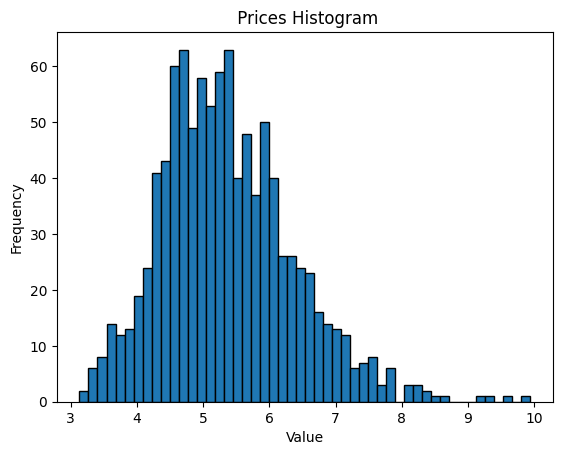

In [3]:
# Create the price histogram
# Your code here
plt.hist(df["prices"], bins=50, edgecolor='black')

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(' Prices Histogram')

# Display the plot
plt.show()

<span style="color:red">*Your description here (double click to open markdown cell): </span>.

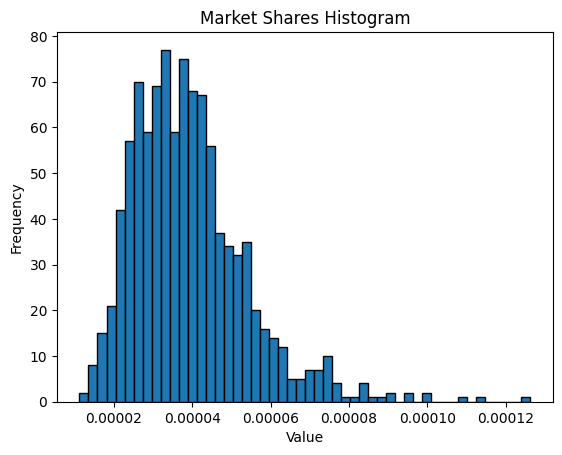

In [4]:
# Create a  shares histogram
# Your code here
plt.hist(df["shares"], bins=50, edgecolor='black')

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Market Shares Histogram')

# Display the plot
plt.show()

<span style="color:red">*Your description here (double click to open markdown cell): </span>.


In [5]:
# Your code here

<span style="color:red">*Your description here (double click to open markdown cell): </span>.


### Part 2: Simple Logit Estimation (40 points)

**Exercise 1**

Estimate the simple logit model disregarding consumer heterogeneity:

$$ ln(s_j) - ln(s_0) =   \beta x_j + \alpha p_{jt} + \xi_{jt} $$


To estimate the model you need to follow these steps: 

1. Calculate the outside good share $s_0$
2. Create the dependent variable $\ln(s_{jt}) - \ln(s_{0t})$
3. Perform the regression and report the estimated coefficients


In [6]:
# Your code here 
df_group_marked_id = df.groupby('market_ids').sum()
outside_good_share = np.repeat((1 - np.array(df_group_marked_id['shares'])), 10)
y = np.log(df['shares']) - np.log(outside_good_share)
x = df[['prices','char1', 'xi']]


#  Use stats model for the regression
mod = sm.OLS(y, x).fit()
print(mod.summary()) 


                                 OLS Regression Results                                
Dep. Variable:                 shares   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          5.894e+05
Date:                Fri, 15 Dec 2023   Prob (F-statistic):                        0.00
Time:                        11:28:02   Log-Likelihood:                         -2.3955
No. Observations:                1000   AIC:                                      10.79
Df Residuals:                     997   BIC:                                      25.51
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**Exercise 2**

Compare the estimates with the true estimates. What is wrong here? (100w)


<span style="color:red">*Your description here (double click to open markdown cell): </span>


**Exercise 3** 

One of the most important concerns regarding heterogeneous product demand estimation is price endogeneity. Econometricians do not observe product-specific demand shocks that might affect the estimation. Imagine that you are buying chocolate in the supermarket. One chocolate brand, Tim Choconotlonely, advertised last month that their cocoa beans are ethically sourced and their suppliers receive fair compensation for their work. People liked the advertising campaign so much that Tim Choconotlonely increased its prices. The details of the campaign are not known to the econometrician and cannot be included in the estimation.

Keeping this in mind, estimate the simple model disregarding consumer heterogeneity and product fixed effects $\xi_{jt}$: 

$$ ln(s_{jt}) - ln(s_0) =   \beta x_j + \alpha p_{jt} . $$ 

In [7]:
# Your code here

x_2 = df[['prices','char1']]
#  Use stats model for the regression
mod_2 = sm.OLS(y, x_2).fit()
print(mod_2.summary()) 

                                 OLS Regression Results                                
Dep. Variable:                 shares   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          6.967e+05
Date:                Fri, 15 Dec 2023   Prob (F-statistic):                        0.00
Time:                        11:28:02   Log-Likelihood:                         -121.99
No. Observations:                1000   AIC:                                      248.0
Df Residuals:                     998   BIC:                                      257.8
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<span style="color:red">*Your explanation here here (double click to open markdown cell): </span>.


**Exercise 4**

One way to address price endogeneity is by using instruments. In practice, it is common to employ both demand and supply-side instruments in heterogeneous product demand estimation (for additional information on how to construct them, see Reynaert & Verboven (2014)). For this assignment, you will use supply-side instruments: marginal costs (cost in the dataframe).

Utilize the marginal cost as an instrument for price and report the estimated coefficients. 

In [8]:
# Your code here
#  Use stats model for the regression
x_3= df[['cost','char1']]
mod_3 = sm.OLS(df["prices"],x_3 ).fit()
price_pred = mod_3.predict(x_3)
df["predicted_price"] = price_pred


# # Use the estimates for the second stage of the regression 
x_4 =df[['char1','predicted_price']]
mod_4 = sm.OLS(y, x_4).fit()
print(mod_4.summary()) 



                                 OLS Regression Results                                
Dep. Variable:                 shares   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          6.237e+05
Date:                Fri, 15 Dec 2023   Prob (F-statistic):                        0.00
Time:                        11:28:02   Log-Likelihood:                         -177.24
No. Observations:                1000   AIC:                                      358.5
Df Residuals:                     998   BIC:                                      368.3
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

**Exercise 5** 

How did the estimates change when you instrumented prices using costs? Are the observed estimates correct? Why are costs a good instrument for prices in these models?

<span style="color:red">*Your explanation here here (double click to open markdown cell): </span>.

### Part 3 - Guided Random Coefficients Estimation (30 points)

In this part of the exercise you will estimate demand whilst accounting for the heterogeneity in consumer preferences over price. Helper functions have been written for you. 

In random coefficient estimation, the econometrician has to explicitly model the functional form of the market share variable. To estimate the demand coefficients you minimize the distance between the true market shares (observed in the data) and the market shares generated by your structural model.

The coefficients on price are different for each consumer and across time periods. In each time period, each consumer is hit with an independent preference shock over price $\nu_{it}^{p}$. In this assignment, these shocks are i.i.d. standard normal random variables. The econometrician does not know the realized value of the shocks or their underlying distribution. However,  the hsockes can be approximated by Monte Carlo simulaton. 





In [9]:
# The number of firms 
n_firms = 10

# The number of consumers 
n_cons = 10000

# The number of time periods
T = 100

**Step 1**
Run the function that simulates the random coefficients on price 

In [10]:
def gen_price_random_coeff(alpha_sd, v_p, df): 
        
        """
        Function writing the random coefficient of the utility 

        Inputs: 

        alpha_sd: the standard deviation of the price coefficients, \sigma_{\alpha} in model
        v_p: random shocks, $\nu_{it}^{p}$ in model 
        df (pandas.core.frame.DataFrame): dataframe 

        Outputs: 

        \sigma_{\alpha} \nu_{it}^{p}p_{jt} in the model 

        """
        random_coefficient_prices = np.zeros((n_firms*n_cons*T, 1))
        alpha_i = np.zeros((n_cons*T, 1))
        for t in range(T):
            price_r = (np.array(df['prices'][t*n_firms : (t + 1)*n_firms])).reshape(1, n_firms)
            period_v_p = v_p[t*n_cons : (t + 1)*n_cons]
            alpha_i_per_period = np.reshape(alpha_sd*period_v_p, 
                                             (n_cons, 1))
            c_times_f = n_cons*n_firms
            alpha_i[t*n_cons: (t + 1)*n_cons] = alpha_i_per_period 
            reshaped =  np.reshape(np.ravel((alpha_i_per_period*price_r).T), (c_times_f, 1))
            random_coefficient_prices[t*c_times_f : (t + 1)*c_times_f] = reshaped
        return random_coefficient_prices

**Step 2**

Run the function that calculates estimated mean utilities 

In [11]:
def gen_estimated_utilities(alpha_mean, beta, df): 
    """

        Function retriving mean utilities 

        Inputs: 

        alpha_mean: the mean value of the price coefficients, \mu_{\alpha} in model
        beta: characteristic coefficient 
        df: (pandas.core.frame.DataFrame) dataframe 

        Outputs: 

        \delta_{jt} in model

     """

    estimated_mean_utlities = np.zeros((n_firms*T, 1))
    for t in range(T):
        price_r = np.array(df['prices'][t*n_firms : (t + 1)*n_firms]).reshape(n_firms, 1)
        product_chars_period = np.array(df['char1'][t*n_firms : (t + 1)*n_firms]).reshape(n_firms, 1)
        xi_per = np.array(df['xi'][t*n_firms : (t + 1)*n_firms]).reshape(n_firms, 1)
        mean_indirect_utilities_period = beta*product_chars_period + alpha_mean*price_r + xi_per
        reshaped = np.reshape(mean_indirect_utilities_period, (n_firms, 1))
        estimated_mean_utlities[t*n_firms:(t + 1)*n_firms] = reshaped
    return estimated_mean_utlities


**Step 3** 

Run the function that calculates estimates market shares

In [12]:
def gen_estimated_market_share(theta, v_p, df):

    """
        Function for retriving estimated market shares

        Inputs: 

        theta: list with [standard deviation price coefficient, mean price coefficient, characteristic coefficient]
        v_p: random shocks, $\nu_{it}^{p}$ in model 
        df: (pandas.core.frame.DataFrame) dataframe 

        Outputs: 

        s_{jt} in the model
     """
    

    alpha_sd = theta[0]
    alpha_mean = theta[1]
    beta = theta[2]

    estimated_market_shares = np.zeros((n_firms*T, 1))
    random_coeff_price = gen_price_random_coeff(alpha_sd, v_p, df)
    mean_utilities = gen_estimated_utilities(alpha_mean, beta, df)
    
    for t in range(T):
        c_times_f = n_cons*n_firms
        coeff_per_T = random_coeff_price[t*c_times_f : (t + 1) * c_times_f]
        repeat_u = np.repeat(mean_utilities[t*n_firms : (t + 1)*n_firms]
                             , n_cons, axis=0)                
        u = repeat_u + coeff_per_T 
        u_r = np.reshape(u, (n_firms, n_cons))
        sum_u = np.sum(np.exp(u_r), axis=0)
        all_probs = np.exp(u_r)/(1 + sum_u)
        market_shares = np.sum(all_probs, axis=1)/n_cons
        reshaped = np.reshape(market_shares, (n_firms, 1))
        estimated_market_shares[t*n_firms:(t + 1)*n_firms] = reshaped

    return estimated_market_shares

**Exercise 2** 

Write the ojective function of the optimization. The objective function should minimize the distance between the true share vector and the estimated share vector. 

In [13]:
# Your code here
def f(theta, v_p, df):
    true_shares = np.array(df['shares'])
    estimated_market_shares = gen_estimated_market_share(theta, v_p, df)
    A = np.log(true_shares)
    B = np.log(estimated_market_shares)
    val = np.square(np.subtract(A, B)).mean()
    return val

**Exercise 3** 

Optimize your function f using scipy.optimize.minimize. 

theta_0 represent the starting value vector from your approximation. You can build it using the estimates from part 2. 

In [14]:
theta_0= [0.1,  1 ,  1 ]


N_simulation = 5

results = np.zeros((N_simulation, 3))

for n in range(N_simulation):
    v_p_monte = np.random.normal(0, 1, (n_cons*T, 1))
    res = optimize.minimize(f, theta_0, args=(v_p_monte, df), bounds=((0., 1.), (-3., -1.), (-2., -0.5)))
    results[n,:] = res.x



print(results)


[[ 0.49955069 -1.52471705 -1.19608748]
 [ 0.53945713 -1.71417806 -1.10078024]
 [ 0.52674564 -1.65135768 -1.13448259]
 [ 0.57427031 -1.83229205 -1.06019717]
 [ 0.57379906 -1.8477929  -1.04485077]]


**Exercise 4**


Calculate the mean value of the coefficients over all the Monte Carlo simulations. How do these results compare to your results in Part 2?

In [15]:
# Your code here 
print(results.mean(axis=0))


[ 0.54276457 -1.71406755 -1.10727965]


<span style="color:red">*Your explanation here (double click to open markdown cell): </span>.

### Part 4: Calculate price elasticies (20 points)

Calculate average own-price elasticities using the parameters estimated with the simple logit and the random coefficients estimates and discuss your results (max 150w). 

In [16]:
# Your code here for estimates from the simple logit estimation


In [17]:
# Your code here for estimates from the random coefficients estimation 

<span style="color:red">*Your explanation here (double click to open markdown cell): </span>

### Part 5. Bonus Question (not mandatory)


Estimate the model in the more realistic case where you do not know the product-specific fixed effects $\xi_{jt}$. Use the costs in the dataframe as instruments.

In the _outer loop_, the GMM estimation procedure relies on the properties of the price instruments to retrieve the unbiased price coefficients. Again, use marginal costs as the instruments. 

Utilize the functions built for you in the guided Monte Carlo Estimation. Refer to the description offered by (Nevo, 2000).




### References


Berry, S. T. (1994). Estimating discrete-choice models of product differentiation. The RAND Journal of Economics, 242-262.


Berry, S. T., & Haile, P. A. (2020). Nonparametric identification of differentiated products demand using micro data (No. w27704). National Bureau of Economic Research.


Nevo, A. (2000). A practitioner's guide to estimation of random‐coefficients logit models of demand. Journal of economics & management strategy, 9(4), 513-548.
Chicago	


Reynaert, M., & Verboven, F. (2014). Improving the performance of random coefficients demand models: The role of optimal instruments. Journal of Econometrics, 179(1), 83-98.


<sub><sup> This assignment was developed by Ana Popovici, 11/2023</sup></sub>